In [ ]:
!pip install biosignalsnotebooks

In [ ]:
import biosignalsnotebooks as bsnb
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
from scipy import signal
from numpy import linspace, max, min, average, std, sum, sqrt, where, argmax, mean

In [ ]:
def get_trial(number):
    return trials.get(number)

trial1 = np.genfromtxt('trial1.txt')[5:]
trial2 = np.genfromtxt('trial2.txt')[5:]
trial3 = np.genfromtxt('trial3.txt')[5:]
fs = 1000
trials = {
    1: trial1,
    2: trial2,
    3: trial3
}

In [ ]:
trial = 1
trial_data = get_trial(trial)

#either EMG, resp, or accelerometer
gnd = trial_data[2000:30000,8]
raw1 = trial_data[2000:30000,5]-gnd #looks like resp
raw2 = trial_data[2000:30000,6]-gnd #looks like acc
raw3 = trial_data[2000:30000,7]-gnd #looks like EMG

time = bsnb.generate_time(raw1, fs)
time = np.array(time)

In [ ]:
#EMG filtering
low = 20/(fs/2)
high = 450/(fs/2)
b, a = sp.signal.butter(4, [low,high], btype='bandpass')
emg_zeromean = (raw3 - mean(raw3))
emg_filtered = sp.signal.filtfilt(b, a, emg_zeromean)

#Teager–Kaiser energy operator signal
tkeo = []
for i in range(0, len(time)):
    if i == 0 or i == len(time) - 1:
        tkeo.append(emg_filtered[i])
    else:
        tkeo.append(np.power(emg_filtered[i], 2) - (emg_filtered[i + 1] * emg_filtered[i - 1]))


#running average filter for smoothing
N = 500
smooth_signal = np.convolve(tkeo, np.ones(N)/N, mode='valid')
steps = sp.signal.find_peaks(smooth_signal,height=750,distance=500)

#FFT, look at reasonable walking cadences, 90/2 to 180/2 steps per minute
b, a = sp.signal.butter(2, [0.5/(fs/2),5/(fs/2)], btype='bandpass')
smooth_filtered = sp.signal.filtfilt(b, a, smooth_signal)

fft_vals = np.fft.fft(smooth_filtered)
fft_freq = np.fft.fftfreq(len(fft_vals), 1/fs)
half_n = len(fft_vals)//2
fft_vals = fft_vals[:half_n]
fft_freq = fft_freq[:half_n]
step_freq = fft_freq[argmax(abs(fft_vals[1:]))]

Average Strikes per minute: 170.17562997709172


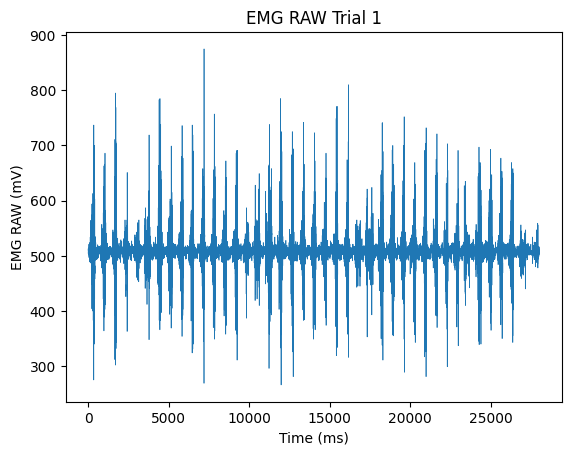

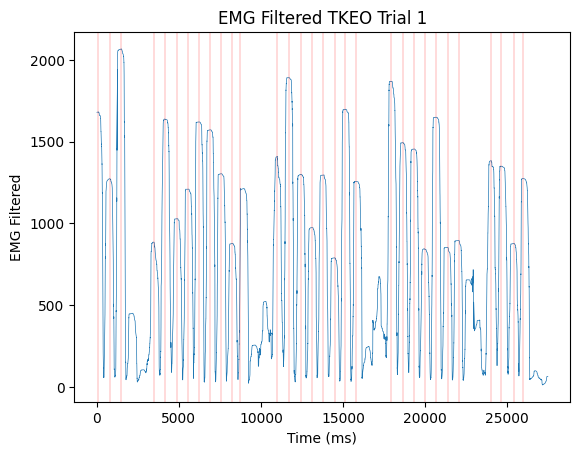

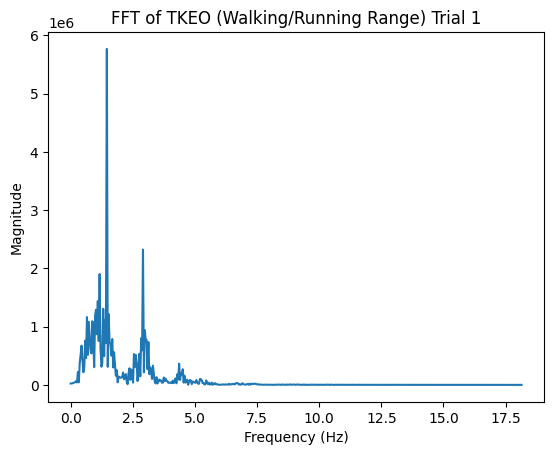

In [ ]:
#EMG plotting
#raw data
fig = plt.figure()
plt.plot(raw3,linewidth=0.5)
plt.title('EMG RAW ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('EMG RAW (mV)')

#filtered with steps
fig = plt.figure()
plt.plot(smooth_signal,linewidth=0.5)
for i in range(len(steps[0])):
  plt.axvline(steps[0][i],color='r',linewidth=0.2)
plt.title('EMG Filtered TKEO ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('EMG Filtered')

#fft of filtered signal
plt.figure()
plt.plot(fft_freq[:500], np.abs(fft_vals[:500]))
plt.title('FFT of TKEO (Walking/Running Range) ' + 'Trial ' + str(trial))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

print('Average Strikes per minute: ' + str(step_freq*60*2))

In [ ]:
#Resp Filtering - 0.2 to 0.33 Hz
low = 0.05/(fs/2)
high = 1/(fs/2)
b, a = sp.signal.butter(2, [low, high], btype='bandpass')
resp_zeromean = (raw1 - mean(raw1))
resp_filtered = sp.signal.filtfilt(b, a, resp_zeromean)

#get freq of breathing over time
f,t,Sxx = sp.signal.spectrogram(resp_filtered,fs=fs,nperseg=2048,noverlap=1024,nfft=4096)

Text(0, 0.5, 'Frequency (Hz)')

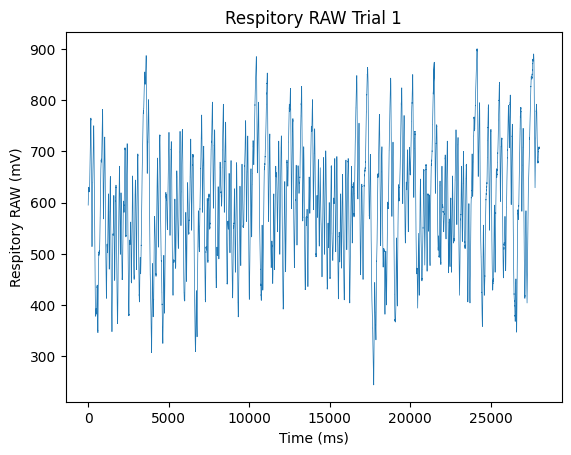

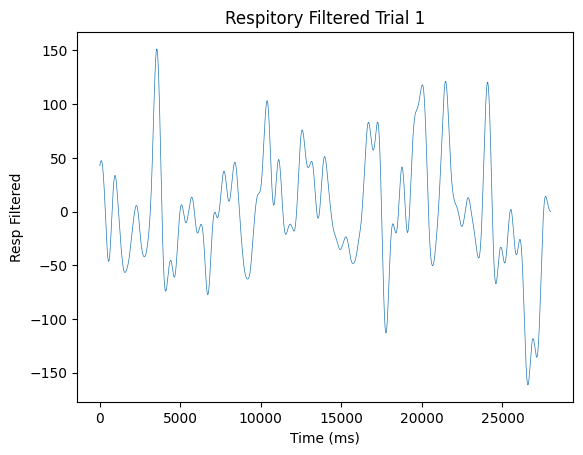

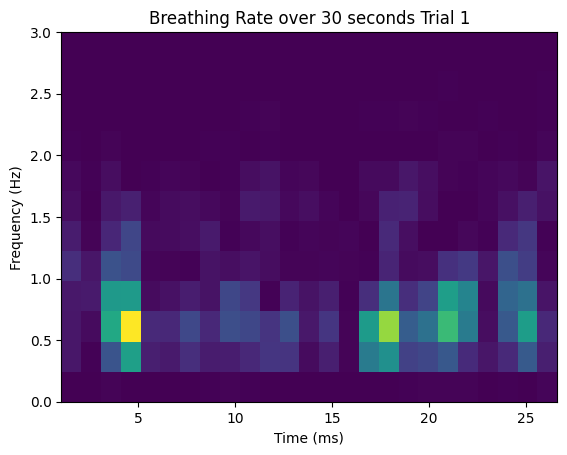

In [ ]:
#Resp plotting
#raw data- looks like breathing with movement pattern
fig = plt.figure()
plt.plot(raw1,linewidth=0.5)
plt.title('Respitory RAW ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('Respitory RAW (mV)')

#filtered signal
fig = plt.figure()
plt.plot(resp_filtered,linewidth=0.5)
plt.title('Respitory Filtered ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('Resp Filtered')

#spectrogram
fig,ax = plt.subplots()
T, F = np.meshgrid(t, f)
c = ax.pcolormesh(T, F, Sxx[:-1,:-1], shading='flat')
ax.set_ylim(0,3)
plt.title('Breathing Rate over 30 seconds ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

In [ ]:
#ACC Filtering 0.5Hz-20Hz for human motion
low = 0.5/(fs/2)
high = 5/(fs/2)
b, a = sp.signal.butter(2, [low, high], btype='bandpass')
acc_zeromean = (raw2 - mean(raw2))
acc_filtered = sp.signal.filtfilt(b, a, acc_zeromean)

f,t,Sxx = sp.signal.spectrogram(acc_filtered,fs=fs,nperseg=2048,noverlap=1024,nfft=4096)

#FFT
acc_filtered_detrend = acc_filtered - np.mean(acc_filtered)
fft_vals = np.fft.fft(acc_filtered_detrend)
fft_freq = np.fft.fftfreq(len(fft_vals), 1/fs)
half_n = len(fft_vals)//2
fft_vals = fft_vals[:half_n]
fft_freq = fft_freq[:half_n]
arm_freq = fft_freq[argmax(abs(fft_vals[1:]))]

Average Arm Swings per minute: 85.71428571428571


Text(0, 0.5, 'Frequency (Hz)')

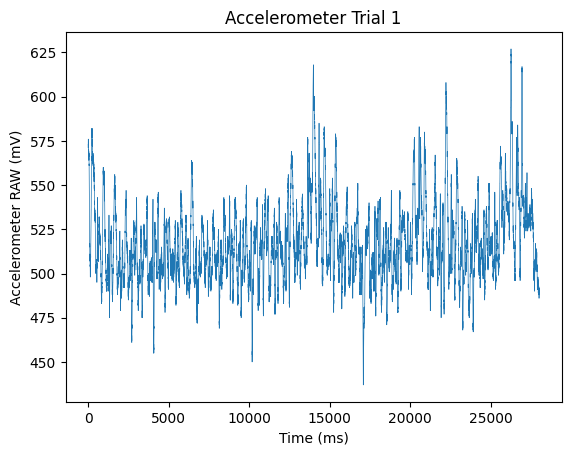

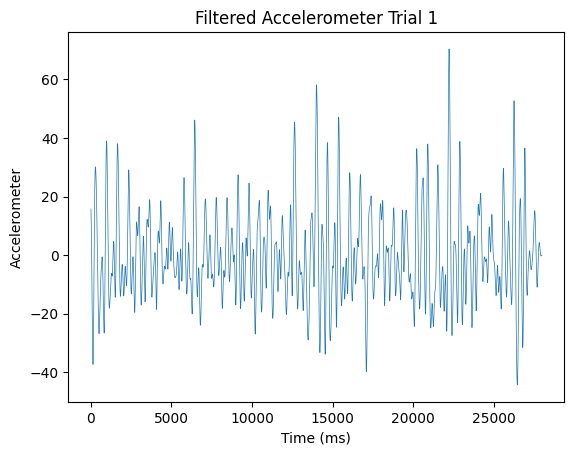

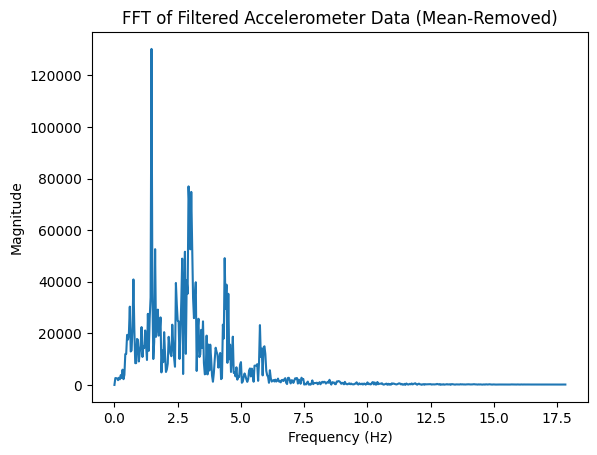

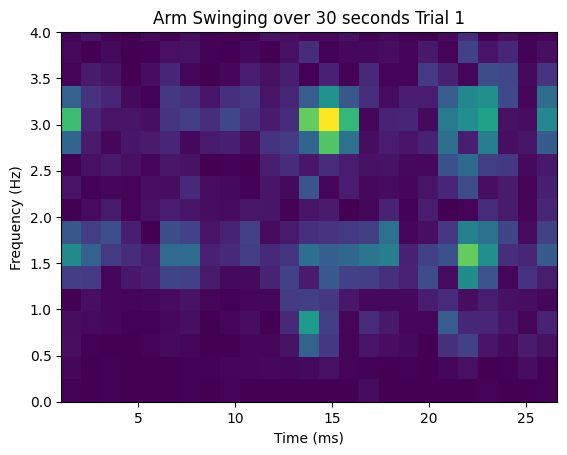

In [ ]:
#ACC plotting
#raw data
fig = plt.figure()
plt.plot(raw2,linewidth=0.5)
plt.title('Accelerometer ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('Accelerometer RAW (mV)')

#filtered signal
fig = plt.figure()
plt.plot(acc_filtered,linewidth=0.5)
plt.title('Filtered Accelerometer ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('Accelerometer')

#fft of filtered signal
plt.figure()
plt.plot(fft_freq[:500], np.abs(fft_vals[:500]))
plt.title('FFT of Filtered Accelerometer Data (Mean-Removed)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

print('Average Arm Swings per minute: ' + str(arm_freq*60))

#spectrogram
fig,ax = plt.subplots()
T, F = np.meshgrid(t, f)
c = ax.pcolormesh(T, F, Sxx[:-1,:-1], shading='flat')
ax.set_ylim(0,4)
plt.title('Arm Swinging over 30 seconds ' + 'Trial ' + str(trial))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')